In [1]:
# interpolate_trial

#This script is a trial script to generate pressure gradients in the interpolation data for sea surface heights.
import numpy as np 
import netCDF4 as nc4 
import pandas as pd 
import os 
import generalfunc as gf
import plots
import cartopy.crs as ccrs
import cartopy.feature as cpf 
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation  

In [2]:
def read_GTSM_map(file):
	GTSM_data= nc4.Dataset(file)
	gtsm_grp=GTSM_data.groups['GTSM Tidal truncated data']
	Xt=np.array(gtsm_grp.variables["FlowElem_xcc"]) #X is longitdue and Y is latitude
	Yt=np.array(gtsm_grp.variables["FlowElem_ycc"])
	Tt=np.array(gtsm_grp.variables["Time"]) 
	Ut=np.array(gtsm_grp.variables["ucx"])
	Vt=np.array(gtsm_grp.variables["ucy"])
	ssht=np.array(gtsm_grp.variables["s1"]) #sea surface heights.
	print("Completed reading GTSM data")
	return (Xt,Yt,Ut,Vt,ssht,Tt)



def read_bdata(file,Bnum):
	prefix="BUOY_"
	bname=prefix+Bnum
	print("Reading data for "+bname)
	file=file+bname+'.csv'
	D=pd.read_csv(file)
	Xib=np.array(D['Lon'])
	Yib=np.array(D['Lat'])
	Tib=np.array(D['Date(GMT)'])
	D.head()
	#velocity computation using the buoy data
	dt=15*60 #sampling time step for each buoy observation.
	Uib=[];Vib=[]
	for j in range(len(Xib)-1):
		dlon=Xib[j+1]-Xib[j]
		dlat=Yib[j+1]-Yib[j]
		lat=Yib[j]
		(dlatm,dlonm)=gf.latlon2meters(lat,dlat,dlon)
		Uib=np.append(Uib,(dlonm)/dt)
		Vib=np.append(Vib,(dlatm)/dt)
	return(Xib,Yib,Uib,Vib,Tib)


In [3]:
# reading nc file and getting the data
fileloc="../../container/Model_n_buoy_data"
Bnum='09' 
sdate=96*16
# indexing=5952-sdate
indexing=3160-sdate

In [4]:
## Reading buoy data.
file =fileloc+"/buoy_data/"
[Xib,Yib,Uib,Vib,Tib]=read_bdata(file,Bnum)
BD={'Xib': Xib,'Yib': Yib,'Uib': Uib,'Vib': Vib,'Tib': Tib} #dictionary for all the vectors.
print(len(Xib))

Reading data for BUOY_09
3161


In [5]:

# #####GTSM data
file=fileloc+"/GTSM_final_truncated.nc"
[Xt,Yt,ut,vt,ssht,Tt]=read_GTSM_map(file)
TD={'Xt': Xt,'Yt': Yt,'ut': ut,'vt': vt,'ssht': ssht,'Tt': Tt}


Completed reading GTSM data


In [6]:
## Processing
prefix="BUOY_"
bname=prefix+Bnum
##Buoy data processing
# BD=FD['BD'] #dictionary where buoy_data is saved.
Xib=BD['Xib'][sdate:]; Yib=BD['Yib'][sdate:]
Uib=BD['Uib'][sdate:]; Vib=BD['Vib'][sdate:]
Tib=BD['Tib'][sdate:]
print(len(Xib))

1625


In [7]:
## Processing GTSM data.
# obtaining GTSM tidal data in vector form interpolated to buoy locations.
sindex=sdate-96
eindex=sindex+indexing
arrlen=eindex-sindex
Xt=TD['Xt']; Yt=TD['Yt']
ut=TD['ut']; vt=TD['vt']
Tt=TD['Tt']; ssht=TD['ssht']
Tt=gf.num2datetimesecs(2014,3,1,sindex,eindex,Tt)
ut=ut[sindex:eindex,:];vt=vt[sindex:eindex,:];ssht=ssht[sindex:eindex,:]
# processing of gtsm data
#interpolating the u and v velocities to the buoy locations.
Buoy_Xi=Xib; Buoy_Yi=Yib#buoy longitude (x position)
Ut=[];Vt=[];Pgxt=[];Pgyt=[];Pgxtr=[];Pgytr=[];Pgxtl=[];Pgytl=[]

In [8]:
from scipy.interpolate import griddata


In [ ]:
llim=0;ulim=-1
Buoy_X=Buoy_Xi[llim:ulim];Buoy_Y=Buoy_Yi[llim:ulim]
path='..'
plots.plticepos(Xib[0:866],Yib[0:866],Xib,Yib,path)



In [ ]:
dlon=1;dlat=0.02
dlonm=dlatm=1
for i in range(len(Buoy_X)):
    xk=Buoy_X[i];yk=Buoy_Y[i]
    pointvec1=np.array([[xk,yk],[xk+dlon,yk],[xk-dlon,yk],[xk,yk+dlat],[xk,yk-dlat]])
    ut_time=ut[llim+i,:];vt_time=vt[llim+i,:];ssht_time=ssht[llim+i,:]
    xp=pointvec1[:,0];yp=pointvec1[:,1]
    grid_z0 = griddata((Xt,Yt), ssht_time, (xp, yp), method='cubic')
#     print(grid_z0)
    dhxr=grid_z0[1]-grid_z0[0]
    dhxl=grid_z0[0]-grid_z0[2]
    dhx=grid_z0[1]-grid_z0[2]
    dhyr=grid_z0[3]-grid_z0[0]
    dhyl=grid_z0[0]-grid_z0[4]
    dhy=grid_z0[3]-grid_z0[4]
    sensx=((dhxr-dhxl)*100)/dhxr
    sensy=((dhyr-dhyl)*100)/dhyr
    print(i)
    print(sensx,sensy)

In [ ]:
#plotting the unstructured grid on a structured grid. 
sizelon=int(1e02)
sizelat=int(8e02)
llon=22;rlon=28
llat=76;rlat=79
lonvec=np.linspace(llon,rlon,sizelon)
latvec=np.linspace(llat,rlat,sizelat)
[longrid,latgrid] = np.meshgrid(lonvec,latvec)
print(np.shape(longrid))
print(np.shape(latgrid))

In [ ]:
ti=15
valgrid=griddata((Xt,Yt), ssht[ti,:], (longrid, latgrid), method='cubic')
print(np.shape(valgrid))

In [ ]:
fig=plt.figure(figsize=(12, 7), frameon=True)
level=np.linspace(-0.5,0.5,150)
cf=plt.contour(longrid,latgrid,valgrid,level)
fig.colorbar(cf)

In [ ]:
import readsimdata
folder='../../container/Buoy_data_excel/procesd_buoy_loc_data_Lars'
BD=readsimdata.readallbuoy(folder)

In [ ]:
# Buoys=['02','03','09','12','13','14','16']
Buoys=['09']
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=25.0,central_latitude=77.0)) 
# ax.set_extent([15,33,74,81]) 
# ax.set_extent([0,40,73,81])
ax.set_extent([24,28,76,78])
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
# *must* call draw in order to get the axis boundary used to add ticks:

# Plotting buoy obs and buoy simulated locations
i=0;pt=96*16
for b in Buoys:
  # Plotting b-uoy obs and buoy simulated locations
    Xib=BD[b+'_x'];Yib=BD[b+'_y']
    plt.scatter(Xib[pt],Yib[pt],color='black',transform=ccrs.PlateCarree())
    plt.text(Xib[pt],Yib[pt], b, transform=ccrs.PlateCarree(),fontsize=15,fontweight='bold')
    plt.plot(Xib[pt:ti+1+pt],Yib[pt:ti+1+pt],transform=ccrs.PlateCarree(),label=b)
    i+=1
# plt.plot(Xib,Yib,color='red',transform=ccrs.PlateCarree(),label='buoy drift')
level=np.linspace(-0.5,1,200)
cp=plt.contour(longrid,latgrid,valgrid,level,transform=ccrs.PlateCarree())
fig.colorbar(cp)

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 
plt.legend(prop={"size":16},framealpha=1)
plt.show()
# plt.savefig('ssh_752_all_b.jpg',dpi=700)
# plt.close(fig) 

In [ ]:
  
# initializing a figure in  
# which the graph will be plotted 
level=np.linspace(-0.5,1,200)
   
# marking the x-axis and y-axis 
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=25.0,central_latitude=77.0)) 
# ax.set_extent([15,33,74,81]) 
ax.set_extent([22,28,76,78])  
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 
level=np.linspace(-1.5,1.5,250)
valgrid=griddata((Xt,Yt), ssht[1360,:], (longrid, latgrid), method='cubic')
cont=ax.contour(longrid,latgrid,valgrid,level,transform=ccrs.PlateCarree())
ax.plot(Xib[0:1360], Yib[0:1360],transform=ccrs.PlateCarree(),color='red')  
fig.colorbar(cont)


In [ ]:
# # initializing a line variable 
line, = ax.plot([], [],transform=ccrs.PlateCarree(),color='red')  
# # contours,=ax.contour([],[],[],[],transform=ccrs.PlateCarree())
# # for index in range(1):
# #     lobj = ax.plot([],[],transform=ccrs.PlateCarree(),color=plotcols[index])[0]
# #     lines.append(lobj)

# # data which the line will  
# # contain (x, y) 
def init():  
    line.set_data([],[])
    return line,
   
def animate(i): 
    global cont
#     x = np.linspace(0, 4, 1000) 
#     line=ax.plot(Xib[0:i],Yib[0:i],transform=ccrs.PlateCarree(),color='red')
    line.set_data(Xib[0:i],Yib[0:i])
    valgrid = griddata((Xt,Yt), ssht[i,:], (longrid, latgrid), method='cubic')
    ax.collections = [] 
    for c in cont.collections:
        c.remove()     
    cont=ax.contour(longrid,latgrid,valgrid,level,transform=ccrs.PlateCarree())
    return cont, line
   
# fig.legend(('obs'))
# fig.colorbar(contours)
anim = FuncAnimation(fig, animate, init_func = init, frames = 20,repeat=False) 

anim.save('trial3.mp4',writer = 'ffmpeg',fps=1)


plt.show()

In [ ]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [30]:
i=632;Pgx=[];Pgy=[];Ut=[];Vt=[];k=500;h=[]
Pgxvec=[];Pgyvec=[]
dlatvec=np.array([0.01,0.02,0.04,0.1,0.25,0.4])
for d in dlatvec:
    Pgx=[];Pgy=[];Ut=[];Vt=[]
    for r in range((1)):
        xk=Xib[i];yk=Yib[i]
        ssht_time=ssht[k,:];ut_time=ut[k,:];vt_time=vt[k,:]
        dlat=d;dlon=d*4
        pointvec=np.array([[xk,yk],[xk+dlon,yk],[xk-dlon,yk],[xk,yk+dlat],[xk,yk-dlat]])
        xp=pointvec[:,0];yp=pointvec[:,1]
        box_x1=xk-2;box_x2=xk+2# box of 4 lon length and 1 lat height to snap obs in that area for computing interpolation.
        box_y1=yk-0.5;box_y2=yk+0.5
        j1=np.where(Xt>=box_x1,Xt,0);j2=np.where(Xt<=box_x2,j1,0)
        i1=np.where(Yt>=box_y1,Yt,0);i2=np.where(Yt<=box_y2,i1,0)
        Xtn=[];Ytn=[]
        ut_ti=[];vt_ti=[];ssht_ti=[]
    #     ssht_time=np.where(ssht_time>1.5,np.nan,ssht_time)
        for j in range(len(j2)):
            if j2[j]!=0 and i2[j]!=0:
                Xtn=np.append(Xtn,j2[j]);Ytn=np.append(Ytn,i2[j])
                ssht_ti=np.append(ssht_ti,ssht_time[j])
                ut_ti=np.append(ut_ti,ut_time[j])
                vt_ti=np.append(vt_ti,vt_time[j])

    #     hist,bin_edges=np.histogram(ssht_ti)
    #     print(min(bin_edges))
    #     print(max(bin_edges))
    #     print(np.shape(Xtn))
    #     print(np.shape(Ytn))
        points=np.array([Xtn,Ytn]).T
        sshgrid = griddata(points, ssht_ti, (xp, yp), method='linear')
        utgrid=griddata(points, ut_ti, (xk, yk), method='linear')
        vtgrid=griddata(points, vt_ti, (xk, yk), method='linear')
        dzx=sshgrid[1]-sshgrid[2]; dzy=sshgrid[3]-sshgrid[4]
        dzxr=sshgrid[1]-sshgrid[0];dzyr=sshgrid[3]-sshgrid[0]
        dzxl=sshgrid[0]-sshgrid[2];dzyl=sshgrid[0]-sshgrid[4]
        dx=111320*(dlon/4.);dy=111320*dlat
    #     print(sshgrid)
        Pgx=np.append(Pgx,dzx/(2*(dx)));Pgy=np.append(Pgy,dzy/(2*dy))
        h=np.append(h,sshgrid[0])
        Ut=np.append(Ut,utgrid)
        Vt=np.append(Vt,vtgrid)
    #     print(Pgx,Pgy)
    #     print(dzxr/(dx),dzxl/(dx))
    #     print(dzyr/dy,dzyl/dy)
        k+=1
    Pgxvec=np.append(Pgxvec,Pgx)
    Pgyvec=np.append(Pgyvec,Pgy)
   

No handles with labels found to put in legend.


Text(0.5, 0, 'dlat')

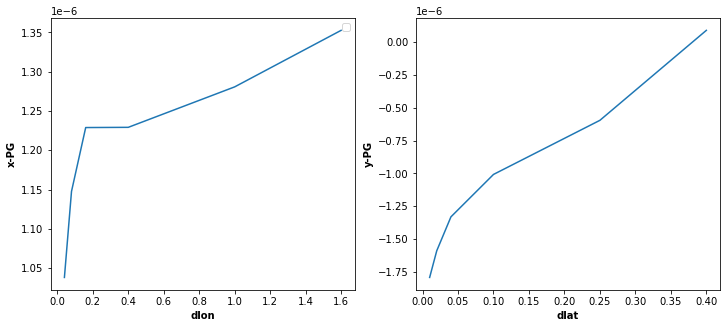

In [31]:
fig=plt.figure(figsize=(12, 5), frameon=True)
plt.subplot(1,2,1)
plt.plot(4.*dlatvec,Pgxvec)
plt.ylabel('x-PG',fontweight='bold')
plt.xlabel('dlon',fontweight='bold')
plt.legend()
plt.subplot(1,2,2)
plt.plot(dlatvec,Pgyvec)
plt.ylabel('y-PG',fontweight='bold')
plt.xlabel('dlat',fontweight='bold')



In [15]:
# verify with simple 1d model
### model constant def.
g=9.81
rho_w=1000.
tmplier=1/60.  #1/30. #multiplier for time reducing time steps in case model has some issues.
days=3600.*24
hours=3600.
omega=(2.0*np.pi)/(24.0*3600)
f=2*omega*np.sin(np.deg2rad(yk))
# friction coeff
Chezy=77
Cbi=g/Chezy**2
Cbi=1*Cbi
print(Cbi)
def modelFx(x,consts,dt):
    [f, H, Pgxt,Pgyt] =consts
    # print("h="+str(consts[1]))
    [u,v] = x
    u_mag = np.sqrt((u)**2+(v)**2)
    Fx=np.zeros(2)
    Fx[0]=-(Cbi*rho_w*u*u_mag /(rho_w*H))+f*(v)-g*( Pgxt)
    Fx[1]=-(Cbi*rho_w*v*u_mag/(rho_w*H))-f*(u)-g*( Pgyt)  
    return (Fx)         
def rk4(x,consts,dt):
    k1=modelFx(x,consts,dt)
    k2=modelFx(x+(dt/2)*k1,consts,dt)
    k3=modelFx(x+(dt/2)*k2,consts,dt)
    k4=modelFx(x+dt*k3,consts,dt)
    Mx=x+(dt/6)*(k1+2*k2+2*k3+k4)
    return Mx

0.0016545791870467197


In [16]:
def simulate(x0,f,Pgx,Pgy,h,times):
    x=x0 ;dt=15*60.
    results=np.zeros((len(x),len(times)))
    ti=0
    # loop
    for t in times:
        results[:,ti]=x[:]     
        Hi=83.
        consts=[f,Hi,Pgx[ti],Pgy[ti]]
        xn=rk4(x,consts,dt)
        x  = xn
        ti+=1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    return(results)

In [17]:
x0=[Ut[0],Vt[0]]
times=range((500))
results=simulate(x0,f,Pgx,Pgy,h,times)

In [ ]:
fig=plt.figure(figsize=(12, 5), frameon=True)
plt.subplot(1,2,1)
plt.plot(results[0,:],label='1D')
plt.plot(Ut,label='GTSM')
plt.ylabel('U tidal vel')
plt.legend()
plt.subplot(1,2,2)
plt.plot(results[1,:],label='1D')
plt.plot(Vt,label='GTSM')
plt.ylabel('V tidal vel')
plt.legend()

In [ ]:
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=25.0,central_latitude=77.0))
# # ax.set_extent([15,33,74,81]) 
ax.set_extent([20,30,76,78]) 
ax.scatter(Xtn,Ytn,transform=ccrs.PlateCarree())
plt.scatter(xp,yp,color='black',transform=ccrs.PlateCarree())
# # ax.plot(Xib, Yib,transform=ccrs.PlateCarree(),color='red') 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 


In [ ]:
OK = OrdinaryKriging(
    Xtn,
    Ytn,
    ssht_ti,
    variogram_model="linear",
    variogram_parameters={'slope': 1.,'nugget': 0.},
    verbose=False,
    enable_plotting=False)
xpn=np.array([xk-dlon,xk,xk+dlon])
ypn=np.array([yk-dlat,yk,yk+dlat])
sshz, ss = OK.execute("grid", xpn, ypn)

In [ ]:
plt.imshow(sshz)
plt.colorbar()

In [ ]:
dzx=sshz[1,2]-sshz[1,0];dzy=sshz[2,1]-sshz[0,1]
dzxr=sshz[1,2]-sshz[1,1];dzyr=sshz[2,1]-sshz[1,1]
dzxl=sshz[1,1]-sshz[1,0];dzyl=sshz[1,1]-sshz[0,1]
dx=111320*(dlon/4.);dy=111320*dlat
print(dzx/(2*(dx)),dzy/(2*dy))
print(dzxr/(dx),dzxl/(dx))
print(dzyr/dy,dzyl/dy)

In [ ]:
import scipy.io
# create a .mat file for cornelis for sea surface heights.

In [ ]:
tvec=[632,840,288,1500]
data={};    j=1
for i in tvec:
    valdict={}
    pname='B9_'+str(j)
    B9ti=i;
    lon=Xib[i];lat=Yib[i]
    #Xt, Yt is gtsm cell centers
    sshti=ssht[i,:]
    uti=ut[i,:];vti=vt[i,:]
    print(len(sshti))
    valdict={'Lon':lon,'Lat':lat,'ssh':sshti,'ut':uti,'vt':vti,'Xt':Xt,'Yt':Yt}
    temp={pname:valdict}
    data.update(temp)
    j+=1
print(data)

In [ ]:
scipy.io.savemat('sshdata.mat', data)

In [ ]:
mat = scipy.io.loadmat('sshdata.mat')

In [ ]:
loc='../../container/Model_n_buoy_data/gtsm_truncated_wd.nc'
GTSM_data= nc4.Dataset(loc)


In [ ]:
gtsm_grp=GTSM_data.groups['GTSM Tidal truncated data']
Xt=np.array(gtsm_grp.variables["FlowElem_xcc"]) #X is longitdue and Y is latitude
Yt=np.array(gtsm_grp.variables["FlowElem_ycc"])
Tt=np.array(gtsm_grp.variables["Time"]) 
wdt=np.array(gtsm_grp.variables["waterdepth"])
print((Xt))

Tests on velocity plots to check for 7.5mins time bias

In [48]:
import importlib
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import plots
import readsimdata
import settings
import generalfunc as gf
import cartopy.crs as ccrs
import cartopy.feature as cpf 
import matplotlib.ticker as mticker
import matplotlib.transforms as transforms
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#plotting parameters.
params = { "pgf.texsystem": "pdflatex",
           "pgf.preamble": [ r"\usepackage[utf8x]{inputenc}",
                             r"\usepackage[T1]{fontenc}",
                             r"\usepackage{cmbright}"],
            'legend.fontsize': '10',
            'axes.labelsize': '11',
            'axes.titlesize':'11',
            'xtick.labelsize':'16',
            'ytick.labelsize':'16',
            "font.weight":'bold'}
plt.rcParams.update(params)

In [65]:
def readdata(Bnum):
    importlib.reload(settings)
    bname='BUOY_'+Bnum
    s=settings.settings()
    forcevec=settings.forcevec;h=settings.h;trate=s['trate']
    (forcenam,folname)=gf.forcedetail(forcevec,trate,h)
    print(folname)
    loc='../../generated_data/'+bname+'/'+folname+'/'
    importlib.reload(readsimdata)
    SD=readsimdata.readsimdata(Bnum,folname)
    return(s,SD,loc)
Bnum='14'
[s,SD,loc]=readdata(Bnum)

h1f1A1T1O1Po1Pt1Bf0


In [66]:
#Transformation of a time vector to remove the year component from it. As we know all the buoys were in 2014.
Ti=SD['T']
T=[]
for i in range(len(Ti)):
    elem=(Ti[i][0:4]+Ti[i][9:15]).replace('-','/')
    T=np.append(T,elem)
importlib.reload(plots)
#Uis is sim and Uib is observed buoy
Uis=SD['Uis'];Vis=SD['Vis']
Uisvec=np.column_stack((Uis,Vis))
Uib=SD['Uib'];Vib=SD['Vib']
Uibvec=np.column_stack((Uib,Vib))
Tib=T
path=loc

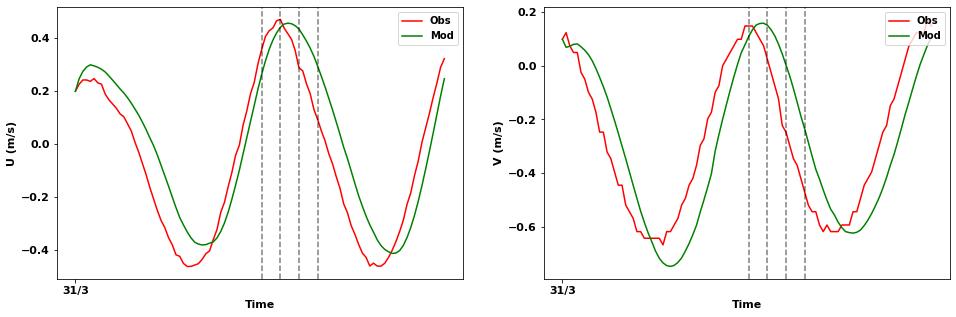

In [68]:
index=index=np.linspace(0,99,100).astype(int)
xcoords = Tib[50:70:5]

fig=plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(Tib[index],Uibvec[index,0],color='r',label='Obs')
plt.plot(Tib[index],Uisvec[index,0],color='g',label='Mod')
plt.xlabel('Time',fontweight='bold')
plt.ylabel('U (m/s)',fontweight='bold')
labels=Tib[::800] 
plt.xticks(labels, labels, rotation='0',fontsize='11')
plt.yticks(fontsize=11)
plt.legend(loc=1) 
for xc in xcoords:
    plt.axvline(x=xc,color='k', linestyle='--',alpha=0.5)              
plt.subplot(1,2,2)
plt.plot(Tib[index],Uibvec[index,1],color='r',label='Obs')
plt.plot(Tib[index],Uisvec[index,1],color='g',label='Mod')
plt.xlabel('Time',fontweight='bold')
plt.ylabel('V (m/s)',fontweight='bold')
labels=Tib[::800] 
plt.xticks(labels, labels, rotation='0',fontsize='11')
plt.yticks(fontsize=11)
for xc in xcoords:
    plt.axvline(x=xc,color='k', linestyle='--',alpha=0.5)
plt.legend(loc=1)
plt.savefig(path+'/initialvel_timebias_2.jpg', format='jpg')
plt.show()
plt.close(fig)

In [69]:
Xis=SD['Xis'];Yis=SD['Yis']
Xib=SD['Xib'];Yib=SD['Yib']

C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\owslib\map\wms111.py:121: UserWarning: Content metadata for layer "GEBCO_LATEST_SUB_ICE_TOPO" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)
C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\owslib\map\wms111.py:121: UserWarning: Content metadata for layer "GEBCO_LATEST" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)
C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\owslib\map\wms111.py:121: UserWarning: Content metadata for layer "GEBCO_LATEST_2_sub_ice_topo" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)
C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\owslib\map\wms111.py:121: UserWarning: Content metadata for layer "GEBCO_LATEST_2" already exists. Using

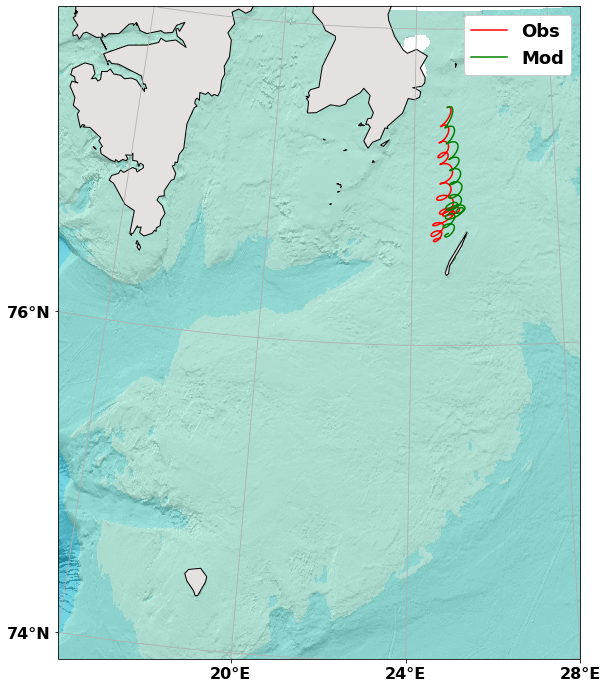

In [70]:
prefix="BUOY_"
bname=prefix+Bnum
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=25.0,central_latitude=77.0)) 
# ax.set_extent([15,33,74,81]) 
ax.set_extent([16,28,74,78]) 
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xticks = [  0, 4, 12, 16, 20, 24, 28, 32, 36]
yticks = [72, 74, 76, 78, 80, 82]
ax.gridlines(xlocs=xticks, ylocs=yticks)
# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
plots.lambert_xticks(ax, xticks)
plots.lambert_yticks(ax, yticks)

# Plotting buoy obs and buoy simulated locations
plt.plot(Xib,Yib,color='red',transform=ccrs.PlateCarree(),label='Obs')
plt.plot(Xis,Yis,color='green',transform=ccrs.PlateCarree(),label='Mod') 
# gebco wms background 
service='https://www.gebco.net/data_and_products/gebco_web_services/web_map_service/mapserv?'
ax.add_wms(service,layers=['GEBCO_LATEST'],wms_kwargs={'width':900*2,'height':600*2})
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 
plt.legend(prop={"size":18},framealpha=1)
# plt.savefig(path+'/sim_ice_drift'+bname+'.jpg',dpi=100)
plt.show()
plt.close(fig) 

In [71]:
# def FTplots(SD,loc,Bnum):
importlib.reload(plots)
#time in hours for FT
Tft=SD['Tft']
argtide=SD['tidearg'];argcor=SD['corarg']
argval=np.append(Tft[argtide],Tft[argcor])
# # X and Y amplitudes (lon and lat)
# units='deg'
# Lonsft=np.row_stack((SD['Xsam'],SD['Xsph']))
# Lonbft=np.row_stack((SD['Xbam'],SD['Xbph']))
# # plot for longitude.
# plots.pltFT(loc,Bnum+'LongitudeFT',Lonsft,Lonbft,units,Tft,argval)
# # latitude
# Latsft=np.row_stack((SD['Ysam'],SD['Ysph']))
# Latbft=np.row_stack((SD['Ybam'],SD['Ybph']))
# # plot for longitude.
# plots.pltFT(loc,Bnum+'LatitudeFT',Latsft,Latbft,units,Tft,argval)
#Velocity
units='m/s'
Usft=np.row_stack((SD['Usam'],SD['Usph']))
Ubft=np.row_stack((SD['Ubam'],SD['Ubph']))
# # plot for u velocity
# plots.pltFT(loc,Bnum+'U-FT',Usft,Ubft,units,Tft,argval)
# Vsft=np.row_stack((SD['Vsam'],SD['Vsph']))
# Vbft=np.row_stack((SD['Vbam'],SD['Vbph']))
# # plot for u velocity
# plots.pltFT(loc,Bnum+'V-FT',Vsft,Vbft,units,Tft,argval)
# print("Fourier Transform plots done.")
xs=Usft
xb=Ubft
tvec=Tft

In [72]:
s=settings.settings()
tidedict=s['tidedict'];cordict=s['cordict']
Tcordict=[];Ttiddict=[]
for k in cordict.keys():
    phi=np.deg2rad(cordict[k])
    f=2*s['omega']*np.sin(phi)
    T=2*np.pi/(f*3600)
    Tcordict=np.append(Tcordict,T)
for k in tidedict.keys():
    Ttiddict=np.append(Ttiddict,tidedict[k])
freqvec=np.append(Ttiddict,Tcordict)
print(freqvec)

[ 6.2103     12.         12.421      12.871      23.934      25.819
 12.44093899 12.22460034]


NameError: name 'name' is not defined

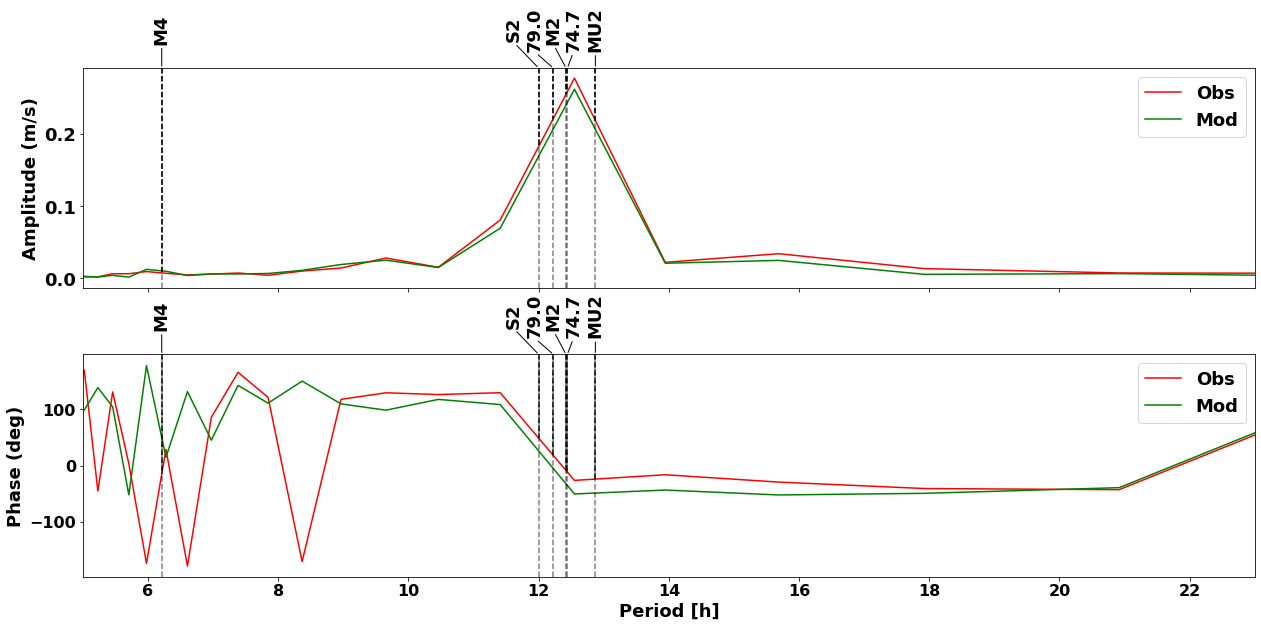

In [84]:
import lineid_plot

fig=plt.figure(figsize=(21,9))
ax1=plt.subplot2grid((2,1), (1,0), rowspan=1, colspan=1)
l1=ax1.plot(tvec,xb[1,:],color='r',label="Obs")
l2=ax1.plot(tvec,xs[1,:],color='g',label="Mod") 
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles,labels,loc=1,fontsize='18')
ax1.set_xlim([5,23])
for xc in freqvec:
    plt.axvline(x=xc,color='k', linestyle='--',alpha=0.5) 
ak = lineid_plot.initial_annotate_kwargs()
tide=np.array(list(s['tidedict'].keys()));cor=np.array(list(s['cordict'].values()))
tidlab=np.append(tide,cor)
lineid_plot.plot_line_ids(tvec, xb[1,:], freqvec, tidlab,ax=ax1,max_iter=30000,label1_size=18)
plt.xlabel('Period [h]',fontsize=18,fontweight='bold')
plt.ylabel('Phase (deg)',fontsize=18,fontweight='bold')
ax2=fig.add_axes([0.125, 0.57, 0.775, 0.34],sharex=ax1)
l1=ax2.plot(tvec,xb[0,:],color='r',label="Obs")
l2=ax2.plot(tvec,xs[0,:],color='g',label="Mod")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles,labels,loc=1,fontsize='18')
for xc in freqvec:
    plt.axvline(x=xc,color='k', linestyle='--',alpha=0.5) 
lineid_plot.plot_line_ids(tvec, xb[0,:], freqvec, tidlab,ax=ax2,max_iter=30000,label1_size=18) #
plt.ylabel('Amplitude ('+units+')',fontsize=18,fontweight='bold')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.xticks(fontsize=18);plt.yticks(fontsize=18)
# plt.savefig(path+'/'+name+'.jpg',format='jpg')
plt.show()
plt.close(fig)